### Network setup

First, let's import the relevant modules.

In [1]:
### Import relevant modules
import sys
from pathlib import Path
import subprocess

# add parent directory to Python path
sys.path.append(str(Path().resolve().parent))

from road import Road
from junction import Junction
from network import Network
import optimization_script_parallel

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Check FFmpeg availability and NVENC support
def check_ffmpeg():
    try:
        result = subprocess.run(['ffmpeg', '-encoders'], capture_output=True, text=True)
        has_ffmpeg = result.returncode == 0
        has_nvenc = 'h264_nvenc' in result.stdout
        print(f"FFmpeg available: {has_ffmpeg}")
        print(f"NVENC (GPU) support: {has_nvenc}")
        if not has_nvenc and has_ffmpeg:
            print("  -> Will use CPU encoding (libx264)")
        return has_ffmpeg, has_nvenc
    except FileNotFoundError:
        print("FFmpeg not found. Install with: sudo apt install ffmpeg")
        return False, False

FFMPEG_AVAILABLE, NVENC_AVAILABLE = check_ffmpeg()

FFmpeg available: True
NVENC (GPU) support: True


Let's setup the roads, the junctions, and the entire toy network.

The toy network we use is as follows:

![Toy Model](toy_model.jpg)

There is one entry road, and the entry road splits into an upper road and a lower road. The upper road then feeds into another upper road, which joins up with the lower road at the exiting junction. 

We set the entry road to have a stable car flow, while the other roads have an initial density of 0, and cars are allowed to freely exit the network at the exit road.

We view the upper roads as part of a residential area, while the lower road is an ordinary road away from the residential area. Accordingly, we set the upper roads to have a lower free flow speed and lower capacity than the lower road.

In [2]:
# Set global parameters for the roads
Road.dt = 0.1 # time step in seconds
Road.p_j = 200 # jam density in vehicles per mile

# Create 4 roads in the network
entry = Road('entry')
road2 = Road('road 2')
road3 = Road('road 3')
road4 = Road('road 4')
exit = Road('exit')

# Set parameters for the roads
entry.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=.9)
entry.set_left_boundary_function(lambda time,sig: .9)

road2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=0)
road3.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=0)

road4.set_params(speed=20,lanes=1,length=1,cap=500,init_density_factor=0)

exit.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=0)
exit.set_right_boundary_function(lambda time,sig: 0) # free outflow


# Create a junction connecting the roads
junction1 = Junction('1-in-2-out')
junction1.set_roads_in(entry).set_roads_out(road2, road4)

junction2 = Junction('1-in-1-out')
junction2.set_roads_in(road2).set_roads_out(road3)

junction3 = Junction('2-in-1-out')
junction3.set_roads_in(road3, road4).set_roads_out(exit)

# Set exit junction
junction3.set_is_exit_junction()

# Create a network with the junctions
network = Network([junction1, junction2, junction3])

# Compute initial distances from exit junction
network.compute_distances(junction3)

{1-in-2-out: 2, 1-in-1-out: 2, 2-in-1-out: 1}

We create a copy of the network, with the exit road having two lanes instead of one lane.

In [3]:
# Create 4 roads in the network
entry_2 = Road('entry')
road2_2 = Road('road 2')
road3_2 = Road('road 3')
road4_2 = Road('road 4')
exit_2 = Road('exit')

# Set parameters for the roads
entry_2.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=.125)
entry_2.set_left_boundary_function(lambda time,sig: .125) # constant inflow of 0.9 vehicles per second

road2_2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=0)
road3_2.set_params(speed=15,lanes=1,length=0.5,cap=400,init_density_factor=0)

road4_2.set_params(speed=20,lanes=1,length=1,cap=500,init_density_factor=0)

exit_2.set_params(speed=20,lanes=2,length=0.5,cap=500,init_density_factor=0)
exit_2.set_right_boundary_function(lambda time,sig: 0) # free outflow


# Create a junction connecting the roads
junction1_2 = Junction('1-in-2-out')
junction1_2.set_roads_in(entry_2).set_roads_out(road2_2, road4_2)

junction2_2 = Junction('1-in-1-out')
junction2_2.set_roads_in(road2_2).set_roads_out(road3_2)

junction3_2 = Junction('2-in-1-out')
junction3_2.set_roads_in(road3_2, road4_2).set_roads_out(exit_2)

# Set exit junction
junction3_2.set_is_exit_junction()

# Create a network with the junctions
network_2 = Network([junction1_2, junction2_2, junction3_2])

# Compute initial distances from exit junction
network_2.compute_distances(junction3_2)

{1-in-2-out: 2, 1-in-1-out: 2, 2-in-1-out: 1}

We can quickly see the initial states of the roads using the `plot_current_density()` method. We confirm that the density along the entry road is at a constant 0.125, while the other roads are initialized to have density 0.

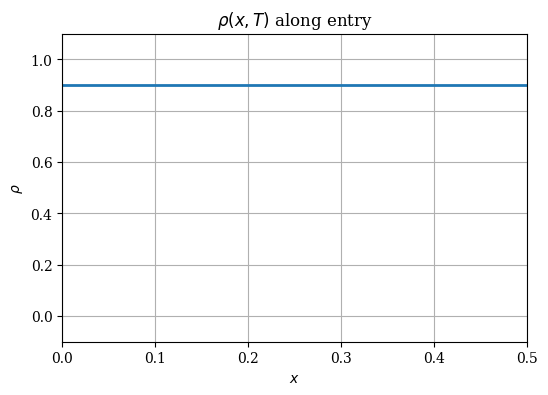

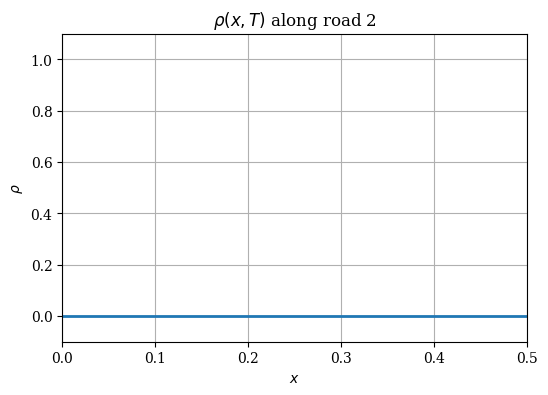

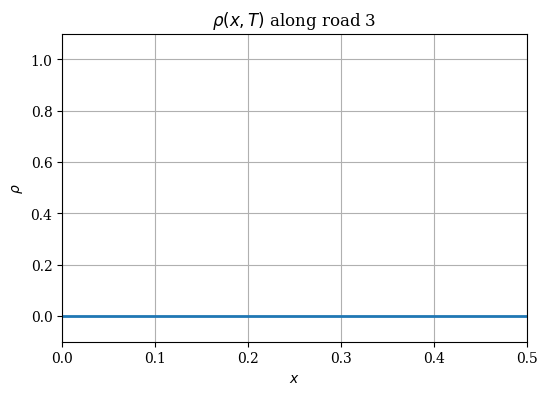

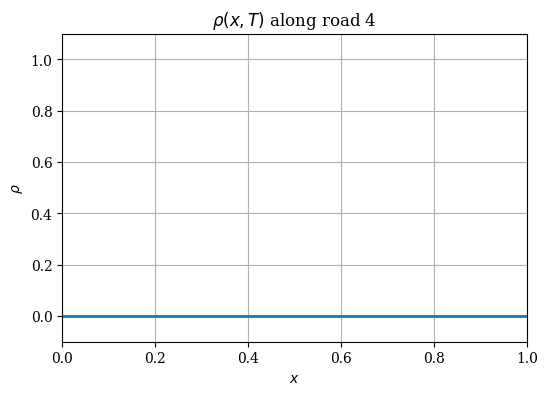

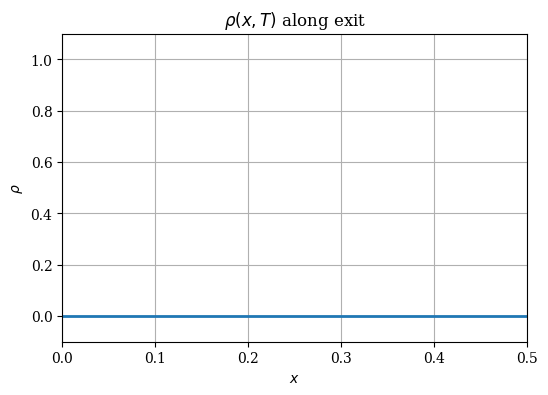

In [4]:
### Plot the roads' initial densities
entry.plot_current_density()
road2.plot_current_density()
road3.plot_current_density()
road4.plot_current_density()
exit.plot_current_density()


### Optimized Parameter Run

Now let's optimize the network. Here, we run the optimization with `nt_opt_val` set to 10. This means that the loss function is the value of the metric (the time-integrated number of cars, scaled by distance) after 10 time steps of the network. Since `nt_opt_val` is such a small value, we expect the optimization to be very local, using only the starting conditions of the network. In fact, because cars closer to the exit are scaled higher, and cars in road 4 are closer by one junction, the optimization should send significantly more cars to road 4 than to road 2.

Indeed, we see that the optimal parameter values for the uncongested initial densities are 0.00195312, indicating that very few cars are sent to road 2.

In [5]:
### Optimize the junction preferences and re-simulate
initial_densities = [0.0325, 0.9]
optimal_parameters = []
optimal_parameters_2 = []

optimization_script_parallel.hyperparameters[-1] = 1  # number of samples for optimization, need to pick 1 here for toy example
for init_density in initial_densities:
    print("------------")
    print("Starting optimization for initial density ", init_density)
    # Set all roads to init_density, except exit which is 0
    for r in network.roads:
        if r.name == 'exit':
            r.set_initial_density_func(lambda x, sig=r.get_sigma(): 0*np.ones_like(x))
        else:
            r.set_initial_density_func(lambda x, sig=r.get_sigma(), density=init_density: density*np.ones_like(x))
    entry.set_left_boundary_function(lambda time, sig, density=init_density: density)

    # Set all roads to init_density, except exit_2 which is 0
    for r in network_2.roads:
        if r.name == 'exit':
            r.set_initial_density_func(lambda x, sig=r.get_sigma(): 0*np.ones_like(x))
        else:
            r.set_initial_density_func(lambda x, sig=r.get_sigma(), density=init_density: density*np.ones_like(x))
    entry_2.set_left_boundary_function(lambda time, sig, density=init_density: density)

    para = optimization_script_parallel.run_optimization(None, network, nt_opt_val=10, output_dir="", by_data=True, save_file=False)
    para_2 = optimization_script_parallel.run_optimization(None, network_2, nt_opt_val=10, output_dir="", by_data=True, save_file=False)
    
    optimal_parameters.append(para)
    optimal_parameters_2.append(para_2)

print("The optimal parameters for the single lane exit are ", optimal_parameters, ".")
print("The optimal parameters for the two lane exit are ", optimal_parameters_2, ".")

------------
Starting optimization for initial density  0.0325
Using 1 processes for parallel gradient computation
Iteration Number: 1 Out of 100
Iteration 1 completed in 0.09 seconds
Iteration Number: 2 Out of 100
Iteration 2 completed in 0.08 seconds
Iteration Number: 3 Out of 100
Iteration 3 completed in 0.08 seconds
Iteration Number: 4 Out of 100
Iteration 4 completed in 0.09 seconds
Iteration Number: 5 Out of 100
Iteration 5 completed in 0.10 seconds
Iteration Number: 6 Out of 100
Iteration 6 completed in 0.09 seconds
Iteration Number: 7 Out of 100
Iteration 7 completed in 0.10 seconds
Iteration Number: 8 Out of 100
Iteration 8 completed in 0.11 seconds
Iteration Number: 9 Out of 100
Iteration 9 completed in 0.11 seconds
Iteration Number: 10 Out of 100
Iteration 10 completed in 0.12 seconds
Iteration Number: 11 Out of 100
Iteration 11 completed in 0.18 seconds
Iteration Number: 12 Out of 100
Iteration 12 completed in 0.11 seconds
Iteration Number: 13 Out of 100
Iteration 13 comple

Simulate the network for 10000 time steps using the optimized parameters.

In [6]:
# Run the two networks with the optimized parameters, saving the metrics for each run
weighted_cars = []
cars_exited = [] 
for i, opt_param in enumerate(optimal_parameters):
    network.set_preferences(opt_param)
    init_density = initial_densities[i]

    # Set all roads to init_density, except exit which is 0
    for r in network.roads:
        if r.name == 'exit':
            r.set_initial_density_func(lambda x, sig=r.get_sigma(): 0*np.ones_like(x))
        else:
            r.set_initial_density_func(lambda x, sig=r.get_sigma(), density=init_density: density*np.ones_like(x))
    entry.set_left_boundary_function(lambda time, sig, density=init_density: density)

    network.reset_by_data()
    # Simulate the network for 10000 time steps
    for _ in range(10000):
        network.evolve_resolve(record_densities=True)
    # Store metrics
    weighted_cars.append(network.get_time_integrated_cars_distance_scaled())
    cars_exited.append(network.get_time_integrated_cars_exited())

weighted_cars_2 = []
cars_exited_2 = [] 
for i, opt_param in enumerate(optimal_parameters_2):
    network_2.set_preferences(opt_param)
    init_density = initial_densities[i]

    # Set all roads to init_density, except exit_2 which is 0
    for r in network_2.roads:
        if r.name == 'exit':
            r.set_initial_density_func(lambda x, sig=r.get_sigma(): 0*np.ones_like(x))
        else:
            r.set_initial_density_func(lambda x, sig=r.get_sigma(), density=init_density: density*np.ones_like(x))
    entry_2.set_left_boundary_function(lambda time, sig, density=init_density: density)

    network_2.reset_by_data()
    # Simulate the network for 10000 time steps
    for _ in range(10000):
        network_2.evolve_resolve(record_densities=True)
    # Store metrics
    weighted_cars_2.append(network_2.get_time_integrated_cars_distance_scaled())
    cars_exited_2.append(network_2.get_time_integrated_cars_exited())

In [7]:
# Print stored metrics and optimal parameters
print("Metrics for single lane exit:")
for i, init_density in enumerate(initial_densities):
    print(f"Initial density: {init_density}, Weighted cars distance scaled: {weighted_cars[i]}, Cars exited: {cars_exited[i]}")
print("Optimal parameters:", [x.item() for x in optimal_parameters])
print("Metrics for two lane exit:")
for i, init_density in enumerate(initial_densities):
    print(f"Initial density: {init_density}, Weighted cars distance scaled: {weighted_cars_2[i]}, Cars exited: {cars_exited_2[i]}")
print("Optimal parameters:", [x.item() for x in optimal_parameters_2])

Metrics for single lane exit:
Initial density: 0.0325, Weighted cars distance scaled: 40.45860253906267, Cars exited: 39.35326822917576
Initial density: 0.9, Weighted cars distance scaled: 851.5556375050326, Cars exited: 126.37499999997934
Optimal parameters: [0.001953125, 0.5]
Metrics for two lane exit:
Initial density: 0.0325, Weighted cars distance scaled: 40.45860253906267, Cars exited: 39.35326822917576
Initial density: 0.9, Weighted cars distance scaled: 762.2495636340877, Cars exited: 227.47500000003456
Optimal parameters: [0.001953125, 0.5]


### Generate Density Evolution Videos

Now let's generate videos showing how the density evolves along the entry road for each case. We re-run the simulations and save the density history as animated GIFs.

In [ ]:
# Generate videos for each simulation case
# Using FFmpeg with NVENC for GPU-accelerated encoding (if available)

num_steps = 10000
frame_skip = 20  # Only render every Nth frame for speed

def animate_fast(road, filename, frame_skip=20):
    """GPU-accelerated animation using FFmpeg NVENC"""
    plt.rcParams['figure.dpi'] = 150
    fig, ax = plt.subplots()
    d_hist = road.get_density_history()[::frame_skip]  # Skip frames
    x = np.linspace(0, road.length, len(d_hist[0]))
    line, = ax.plot([], [], lw=2)
    
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\rho$')
    ax.grid()
    ax.set_ylim([-0.1, road.lanes + 0.1])
    ax.set_xlim([0, road.length])
    
    def animate(t):
        line.set_data(x, d_hist[t])
        ax.set_title(f'$\\rho(x,T)$ along {road.name} at timestep {t * frame_skip}')
        return line,
    
    ani = animation.FuncAnimation(fig, animate, frames=len(d_hist), blit=False)
    
    # Use GPU or CPU encoding based on availability check from imports
    if NVENC_AVAILABLE:
        writer = animation.FFMpegWriter(fps=30, codec='h264_nvenc')
    elif FFMPEG_AVAILABLE:
        writer = animation.FFMpegWriter(fps=30)
    else:
        # Fallback to GIF if no FFmpeg
        writer = animation.PillowWriter(fps=30)
        filename = filename.replace('.mp4', '.gif')
    
    ani.save(filename, writer=writer)
    plt.close(fig)
    return filename

# Single lane exit network
for i, opt_param in enumerate(optimal_parameters):
    network.set_preferences(opt_param)
    init_density = initial_densities[i]

    # Set all roads to init_density, except exit which is 0
    for r in network.roads:
        if r.name == 'exit':
            r.set_initial_density_func(lambda x, sig=r.get_sigma(): 0*np.ones_like(x))
        else:
            r.set_initial_density_func(lambda x, sig=r.get_sigma(), density=init_density: density*np.ones_like(x))
    entry.set_left_boundary_function(lambda time, sig, density=init_density: density)

    network.reset_by_data()
    for _ in range(num_steps):
        network.evolve_resolve(record_densities=True)
    
    filename = f"entry_density_single_lane_density_{init_density}.mp4"
    saved = animate_fast(entry, filename, frame_skip=frame_skip)
    print(f"Saved: {saved}")

# Two lane exit network
for i, opt_param in enumerate(optimal_parameters_2):
    network_2.set_preferences(opt_param)
    init_density = initial_densities[i]

    # Set all roads to init_density, except exit_2 which is 0
    for r in network_2.roads:
        if r.name == 'exit':
            r.set_initial_density_func(lambda x, sig=r.get_sigma(): 0*np.ones_like(x))
        else:
            r.set_initial_density_func(lambda x, sig=r.get_sigma(), density=init_density: density*np.ones_like(x))
    entry_2.set_left_boundary_function(lambda time, sig, density=init_density: density)

    network_2.reset_by_data()
    for _ in range(num_steps):
        network_2.evolve_resolve(record_densities=True)
    
    filename = f"entry_density_two_lane_density_{init_density}.mp4"
    saved = animate_fast(entry_2, filename, frame_skip=frame_skip)
    print(f"Saved: {saved}")

print("\nAll videos generated!")

In [ ]:
# Display one of the generated videos inline (requires IPython)
from IPython.display import Video, display

# Show the first video as an example
display(Video("entry_density_single_lane_density_0.0325.mp4", embed=True))